**Bibliotecas**

In [ ]:
#Coletados Comentários
from google_play_scraper import Sort, reviews

#Armazenamento em DF
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Transformar a coluna de versões para fazer filtro melhores
from packaging.version import parse

#Para realizar paralelismo
import swifter

#Tratamentos
import re
import emoji
import nltk
from nltk.corpus import stopwords
import stanza

#Sentimentos dos Comentários
from pysentimiento import create_analyzer

#Temas dos Comentários
from bertopic import BERTopic

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

c:\Users\Computador\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Download de pacotes
nltk.download("stopwords")
stanza.download('pt')

nlp = stanza.Pipeline(lang='pt', processors='tokenize,mwt,pos,lemma')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Computador\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2025-06-09 20:01:19 INFO: Downloaded file to C:\Users\Computador\stanza_resources\resources.json
2025-06-09 20:01:19 INFO: Downloading default packages for language: pt (Portuguese) ...
2025-06-09 20:01:22 INFO: File exists: C:\Users\Computador\stanza_resources\pt\default.zip
2025-06-09 20:01:25 INFO: Finished downloading models and saved to C:\Users\Computador\stanza_resources
2025-06-09 20:01:25 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-06-09 20:01:25 INFO: Downloaded file to C:\Users\Computador\st

**Funções**

In [44]:
stopwords_pt = set(stopwords.words("portuguese"))
stopwords_pt.update({
    'tim', 'vivo', 'claro'
})

In [46]:
def tratamento_de_texto(texto):
    texto = emoji.demojize(texto, language="pt")
    texto = texto.lower()
    texto = re.sub(r'(:[^:\s]+:)', r' \1 ', texto)
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"[^a-zá-úà-üç\s]", "", texto)
    texto = re.sub(r'\s+', ' ', texto).strip()

    doc = nlp(texto)
    
    lemmas = [word.lemma for sent in doc.sentences for word in sent.words if word.lemma not in stopwords_pt and len(word.lemma) > 2]
    
    return " ".join(lemmas)

In [47]:
analyzers = {
    "sentiment": create_analyzer(task="sentiment", lang="pt"),
    "emotion": create_analyzer(task="emotion", lang="pt"),
}

# Grupos para emoções resumidas
grupos_emocoes = {
    "alegria": ["admiration", "amusement", "approval", "excitement",
                "gratitude", "joy", "love", "optimism", "pride"],
    "tristeza": ["disappointment", "remorse", "sadness"],
    "raiva": ["anger", "annoyance", "disapproval", "disgust"],
    "medo": ["fear", "nervousness", "embarrassment"],
    "surpresa": ["surprise", "realization"],
    "confianca": ["curiosity", "desire", "caring"],
    "confusao": ["confusion"],
    "neutro": ["neutral", None]
}

def analisar_sentimento_todos(texto, analyzers=analyzers):
    if not isinstance(texto, str) or not texto.strip():
        return pd.Series()

    dados = {}

    for tipo, analyzer in analyzers.items():
        resultado = analyzer.predict(texto)

        # Ajuste seguro do output
        if isinstance(resultado.output, list):
            saida = resultado.output[0] if resultado.output else None
        else:
            saida = resultado.output

        # Para emoção, substituir output pela categoria agregada
        if tipo == "emotion":
            # Pós-processamento: agregando emoções
            grupo_probs = {}
            for grupo, emocoes in grupos_emocoes.items():
                soma = sum(resultado.probas.get(e, 0) for e in emocoes)
                dados[f"{tipo}_{grupo}"] = soma
                grupo_probs[grupo] = soma
            
            # Encontrar o grupo com maior probabilidade
            if grupo_probs:
                grupo_principal = max(grupo_probs, key=grupo_probs.get)
            else:
                grupo_principal = None

            dados[f"{tipo}_output"] = grupo_principal
        else:
            # Mantém output original
            dados[f"{tipo}_output"] = saida
            # Mantém probas originais
            for k, v in resultado.probas.items():
                dados[f"{tipo}_{k}"] = v

    return pd.Series(dados)


# Extração de Comentários

In [50]:
qtd_comentarios = 5000

dados_android = []

apps = {
    "Claro": "com.nvt.cs",
    "TIM": "br.com.timbrasil.meutim",
    "Vivo": "br.com.vivo"
}

In [51]:
for app, app_id in apps.items():
    result, _ = reviews(
        app_id,
        lang='pt',
        country='br',
        sort=Sort.NEWEST,
        count=qtd_comentarios
    )
        
    for review in result:
        dados_android.append({
            "app": app,
            "score": review.get("score", None),
            "content": review.get("content", None),
            "app_version": review.get("appVersion", None),
            "date": review.get("at", None),
            "reply_content": review.get("replyContent", None),
            "reply_date": review.get("repliedAt", None)
        })

In [52]:
comentarios_android = pd.DataFrame(dados_android, columns=["date", "score", "app_version", "app",  "content"])

comentarios_android.to_csv("comentarios.csv", index=False)
comentarios_android.head()

,date,score,app_version,app,content
0,2025-06-08 18:03:33,5,18.6.0,Claro,muito bom
1,2025-06-08 17:37:27,1,None,Claro,horrível
2,2025-06-08 17:27:33,4,18.9.0,Claro,serviço atende as minhas expectativas.
3,2025-06-08 17:17:43,1,18.8.0,Claro,"A Claro é um LIXO, fujam de tudo deles."
4,2025-06-08 17:06:50,5,18.8.0,Claro,excelente


# Análise de Sentimento

## Análises

In [48]:
comentarios_android = pd.read_csv("comentarios.csv")

In [53]:
comentarios_android["content_proc"] = comentarios_android["content"].swifter.apply(tratamento_de_texto)

Pandas Apply: 100%|██████████| 15000/15000 [32:19<00:00,  7.73it/s] 


In [54]:
resultados = comentarios_android["content_proc"].swifter.apply(analisar_sentimento_todos)
df = pd.concat([comentarios_android, resultados], axis=1)

Pandas Apply: 100%|██████████| 15000/15000 [22:11<00:00, 11.26it/s] 


In [55]:
df.to_csv("comentarios_processados.csv", index=False)

In [56]:
print("Data mínima da Claro: ", df[df['app']=='Claro']['date'].min())
print("Data mínima da TIM: ", df[df['app']=='TIM']['date'].min())
print("Data mínima da Vivo: ", df[df['app']=='Claro']['date'].min())
print("Data máxima da Claro: ", df[df['app']=='Claro']['date'].max())
print("Data máxima da TIM: ", df[df['app']=='TIM']['date'].max())
print("Data máxima da Vivo: ", df[df['app']=='Claro']['date'].max())

Data mínima da Claro:  2025-04-07 12:36:14
Data mínima da TIM:  2025-04-10 09:55:15
Data mínima da Vivo:  2025-04-07 12:36:14
Data máxima da Claro:  2025-06-08 18:03:33
Data máxima da TIM:  2025-06-08 18:18:48
Data máxima da Vivo:  2025-06-08 18:03:33


### Notas

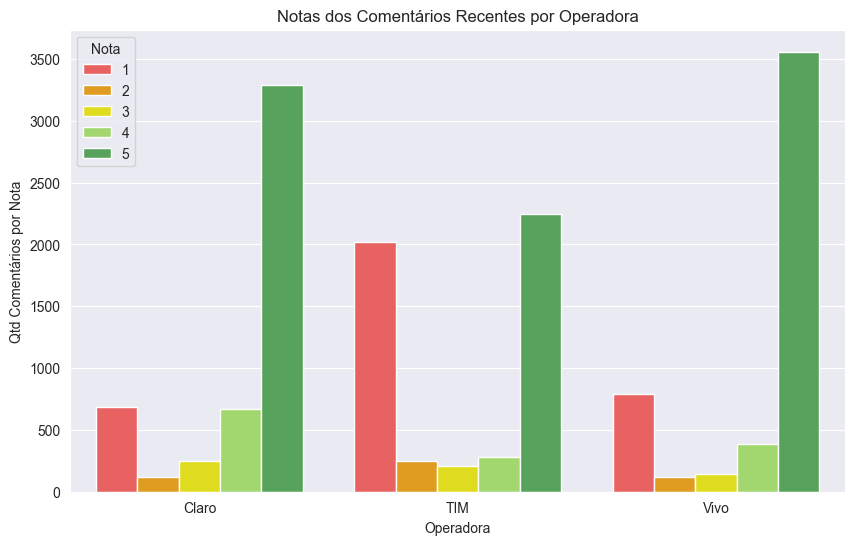

In [57]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# Plotar gráfico com hue simplificado
sns.countplot(
    data=df,
    x='app',
    hue='score',
    palette={1: '#FF4C4C', 2: '#FFA500', 3: "#FFFB00", 4: "#A0E95C", 5: '#4CAF50'},
    hue_order=[1, 2, 3, 4, 5]
)

plt.title("Notas dos Comentários Recentes por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Qtd Comentários por Nota")
plt.legend(title="Nota")

plt.show()

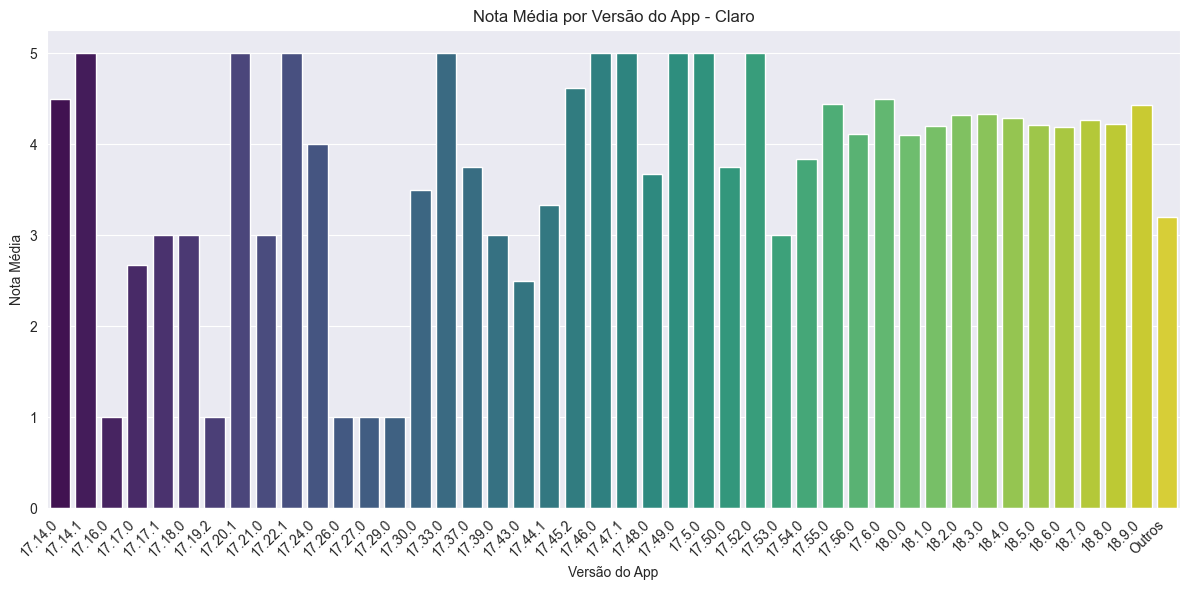

In [58]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('17.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Claro'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gráfico de barras da nota média por versão
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualização
plt.xlabel('Versão do App')
plt.ylabel('Nota Média')
plt.title('Nota Média por Versão do App - Claro')
plt.tight_layout()
plt.show()


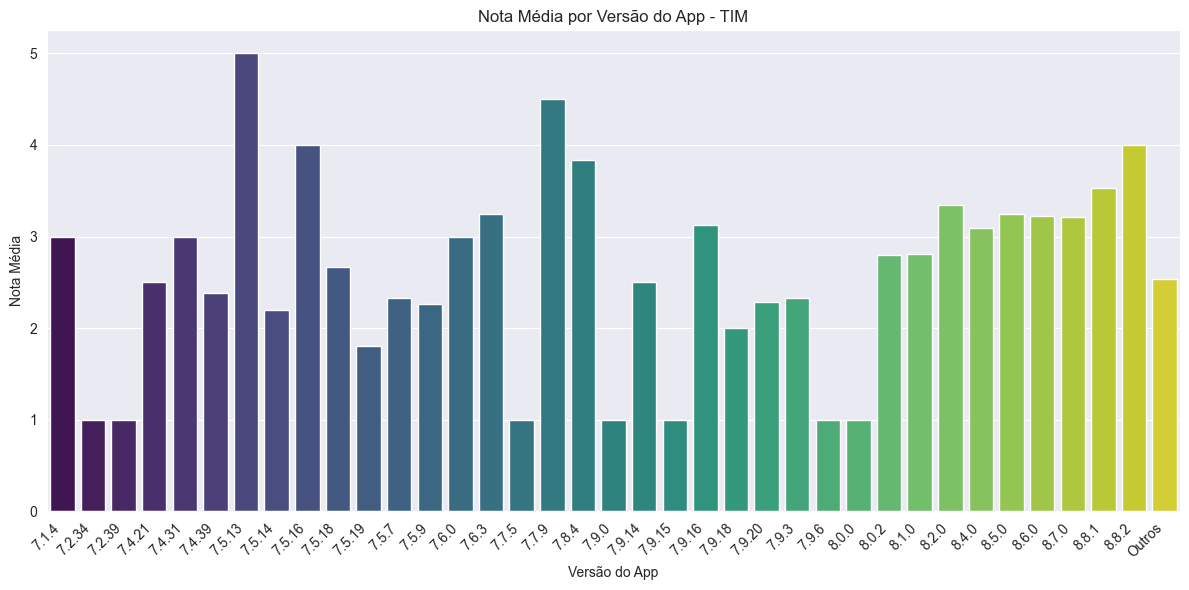

In [59]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('7.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'TIM'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gráfico de barras da nota média por versão
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualização
plt.xlabel('Versão do App')
plt.ylabel('Nota Média')
plt.title('Nota Média por Versão do App - TIM')
plt.tight_layout()
plt.show()

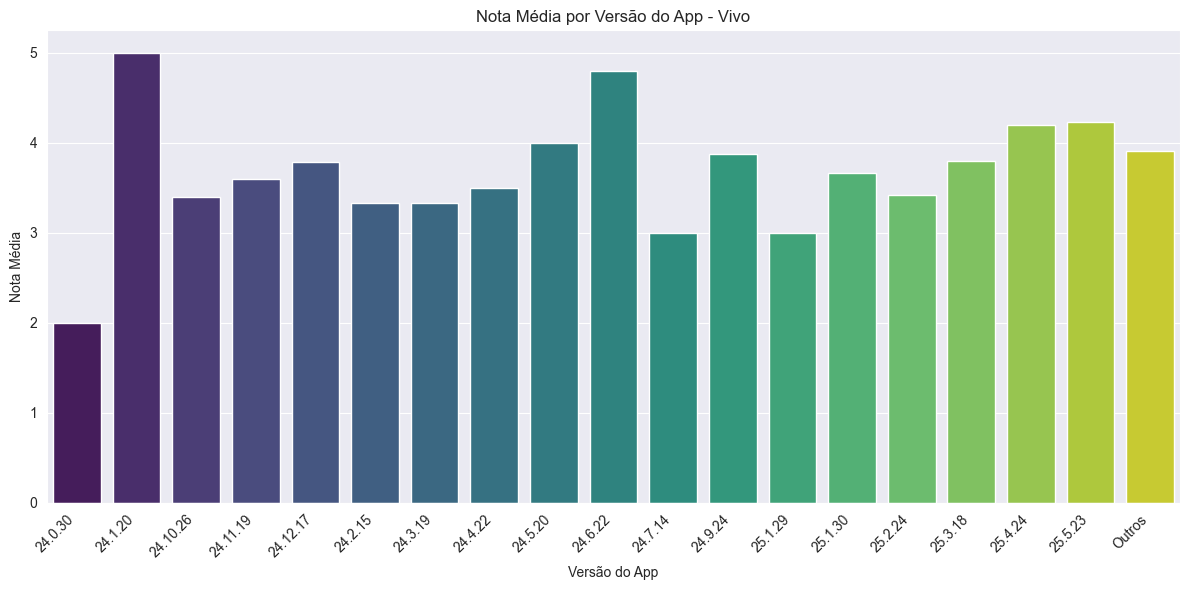

In [60]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('20.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Vivo'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gráfico de barras da nota média por versão
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualização
plt.xlabel('Versão do App')
plt.ylabel('Nota Média')
plt.title('Nota Média por Versão do App - Vivo')
plt.tight_layout()
plt.show()

### Sentimentos por Versão

#### Claro

In [61]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('17.0.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Claro'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada,17.14.0,17.14.1,17.16.0,17.17.0,17.17.1,17.18.0,17.19.2,17.20.1,17.21.0,17.22.1,17.26.0,17.27.0,17.29.0,17.30.0,17.33.0,17.37.0,17.39.0,17.43.0,17.44.1,17.45.2,17.46.0,17.47.1,17.48.0,17.49.0,17.5.0,17.50.0,17.52.0,17.53.0,17.54.0,17.55.0,17.56.0,17.6.0,18.0.0,18.1.0,18.2.0,18.3.0,18.4.0,18.5.0,18.6.0,18.7.0,18.8.0,18.9.0,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NEG,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,9.0,0.0,56.0,22.0,41.0,73.0,125.0,121.0,70.0,40.0,63.0,2.0,136.0
NEU,1.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,7.0,0.0,1.0,2.0,4.0,1.0,4.0,0.0,5.0,12.0,3.0,14.0,1.0,184.0,76.0,172.0,278.0,469.0,366.0,274.0,134.0,288.0,15.0,168.0
POS,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,6.0,4.0,20.0,1.0,105.0,48.0,113.0,203.0,337.0,295.0,174.0,95.0,172.0,6.0,88.0


In [62]:
frequencias = df[df['app'] == 'Claro']['app_version'].value_counts()

limiar = 200
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'Claro']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada,18.0.0,18.2.0,18.3.0,18.4.0,18.5.0,18.6.0,18.7.0,18.8.0,Outros
sentiment_output,,,,,,,,,
NEG,56,41,73,125,121,70,40,63,81
NEU,184,172,278,469,366,274,134,288,180
POS,105,113,203,337,295,174,95,172,107


#### TIM

In [63]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('7.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'TIM'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada,7.1.4,7.2.34,7.2.39,7.4.21,7.4.31,7.4.39,7.5.13,7.5.14,7.5.16,7.5.18,7.5.19,7.5.7,7.5.9,7.6.0,7.6.3,7.7.5,7.7.9,7.8.4,7.9.0,7.9.14,7.9.15,7.9.16,7.9.18,7.9.20,7.9.3,7.9.6,8.0.0,8.0.2,8.1.0,8.2.0,8.4.0,8.5.0,8.6.0,8.7.0,8.8.1,8.8.2,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NEG,2.0,2.0,1.0,1.0,1.0,6.0,0.0,1.0,0.0,2.0,2.0,1.0,7.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,3.0,13.0,12.0,9.0,1.0,1.0,9.0,8.0,83.0,252.0,196.0,486.0,279.0,90.0,3.0,354.0
NEU,1.0,1.0,2.0,4.0,2.0,3.0,1.0,4.0,0.0,0.0,3.0,1.0,5.0,1.0,5.0,0.0,3.0,5.0,1.0,0.0,1.0,5.0,3.0,7.0,7.0,0.0,0.0,16.0,8.0,105.0,228.0,224.0,682.0,318.0,187.0,4.0,323.0
POS,1.0,0.0,0.0,1.0,1.0,3.0,2.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,4.0,0.0,34.0,132.0,101.0,319.0,180.0,66.0,0.0,111.0


In [64]:
frequencias = df[df['app'] == 'TIM']['app_version'].value_counts()

limiar = 200
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'TIM']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada,8.2.0,8.4.0,8.5.0,8.6.0,8.7.0,8.8.1,Outros
sentiment_output,,,,,,,
NEG,83,252,196,486,279,90,141
NEU,105,228,224,682,318,187,121
POS,34,132,101,319,180,66,39


#### Vivo

In [65]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('20.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Vivo'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada,24.0.30,24.1.20,24.10.26,24.11.19,24.12.17,24.2.15,24.3.19,24.4.22,24.5.20,24.6.22,24.7.14,24.9.24,25.1.29,25.1.30,25.2.24,25.3.18,25.4.24,25.5.23,Outros
sentiment_output,,,,,,,,,,,,,,,,,,,
NEG,0.0,0.0,2.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,1.0,4.0,12.0,26.0,63.0,507.0,149.0
NEU,2.0,2.0,3.0,3.0,7.0,1.0,2.0,3.0,2.0,4.0,1.0,3.0,1.0,7.0,18.0,65.0,255.0,1846.0,329.0
POS,0.0,0.0,0.0,1.0,4.0,2.0,0.0,3.0,0.0,1.0,1.0,3.0,0.0,7.0,7.0,18.0,144.0,1229.0,204.0


In [66]:
frequencias = df[df['app'] == 'Vivo']['app_version'].value_counts()

limiar = 50
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'Vivo']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada,25.3.18,25.4.24,25.5.23,Outros
sentiment_output,,,,
NEG,26,63,507,44
NEU,65,255,1846,76
POS,18,144,1229,42


### Sentimentos

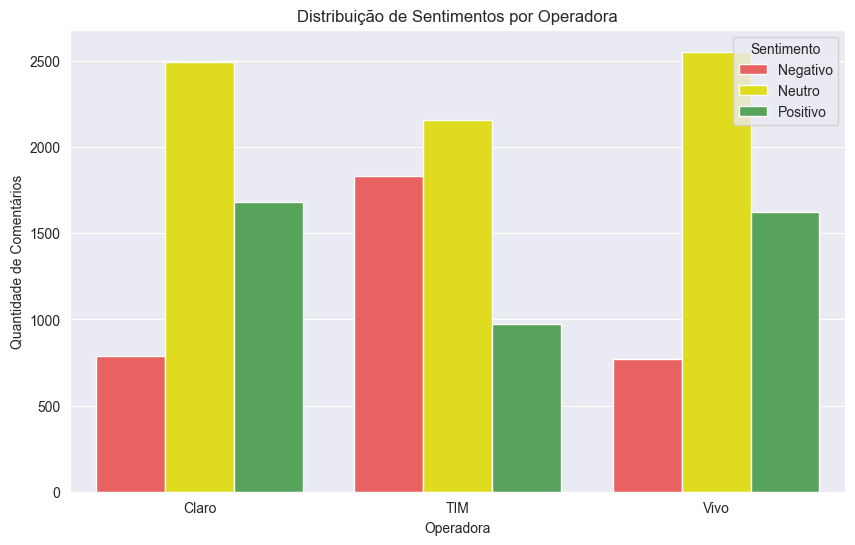

In [67]:
def map_sentiment(sent):
    if sent in ['NEG', 'negativo']:
        return 'Negativo'
    elif sent in ['NEU', 'neutro']:
        return 'Neutro'
    elif sent in ['POS', 'positivo']:
        return 'Positivo'
    else:
        return 'Outro'

df['sentimento_simplificado'] = df['sentiment_output'].apply(map_sentiment)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_simplificado',
    palette={'Negativo': '#FF4C4C', 'Neutro': '#FFFB00', 'Positivo': '#4CAF50'},
    hue_order=['Negativo', 'Neutro', 'Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.legend(title="Sentimento")

plt.show()


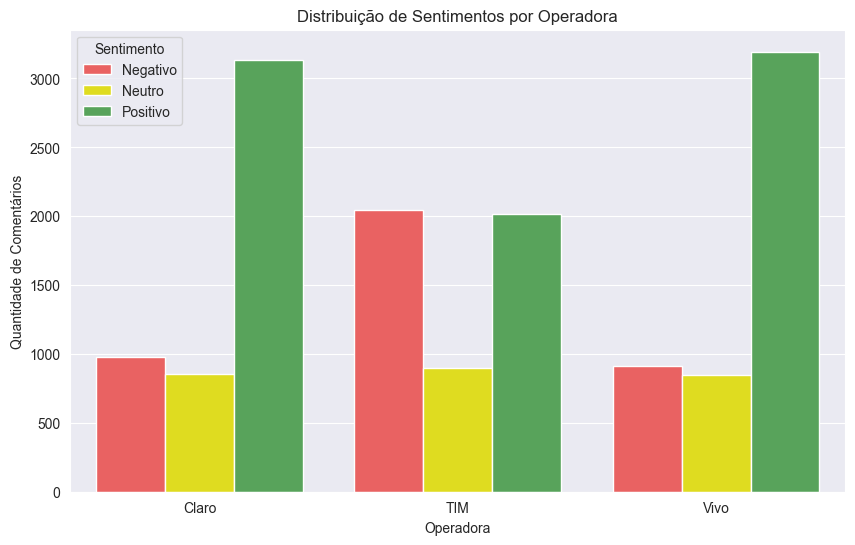

In [22]:
def map_sentiment(row, limiar_neu=0.7):
    sentiment = row.get('sentiment_output', '')
    if sentiment == 'NEG':
        return 'Negativo'
    elif sentiment == 'POS':
        return 'Positivo'
    elif sentiment == 'NEU':
        prob_pos = row.get('sentiment_POS', 0)
        prob_neu = row.get('sentiment_NEU', 0)
        prob_neg = row.get('sentiment_NEG', 0)
        if prob_neu >= limiar_neu:
            return "Neutro"
        return "Positivo" if prob_pos > prob_neg else "Negativo"
    else:
        return sentiment

df['sentimento_simplificado'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_simplificado',
    palette={'Negativo': '#FF4C4C', 'Neutro': '#FFFB00', 'Positivo': '#4CAF50'},
    hue_order=['Negativo', 'Neutro', 'Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.legend(title="Sentimento")

plt.show()

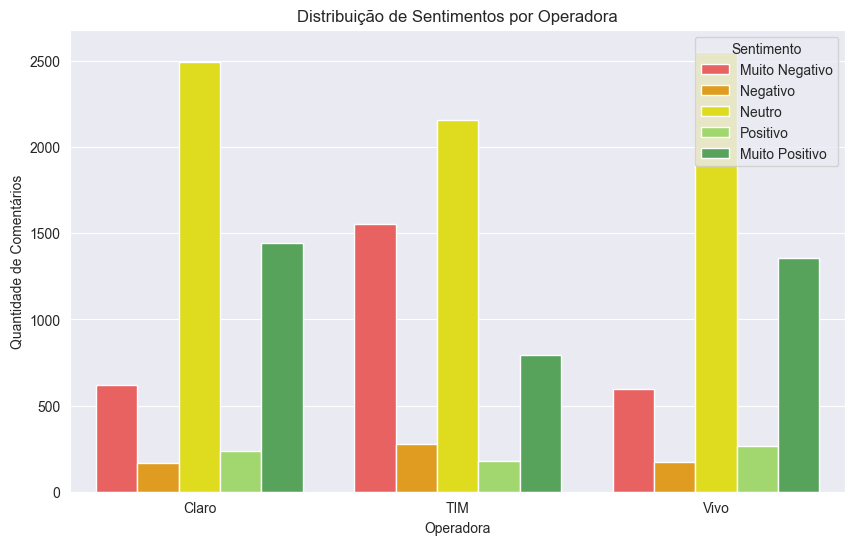

In [68]:
def map_sentiment(row):
    sentiment = row['sentiment_output']
    if sentiment == "NEG":
        prob = row.get('sentiment_NEG', 0)
        if prob < 0.8:
            return "Negativo"
        else:
            return "Muito Negativo"
    elif sentiment == "POS":
        prob = row.get('sentiment_POS', 0)
        if prob < 0.8:
            return "Positivo"
        else:
            return "Muito Positivo"
    elif sentiment == "NEU":
        return "Neutro"
    else:
        return sentiment
df['sentimento_complexo'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_complexo',
    palette={'Muito Negativo': '#FF4C4C', 'Negativo': '#FFA500', 'Neutro': "#FFFB00",
             'Positivo': "#A0E95C", 'Muito Positivo': '#4CAF50'},
    hue_order=['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.legend(title="Sentimento")

plt.show()

In [6]:
df[(df["sentiment_output"] == "NEU") & (df["sentiment_NEU"] < 0.5)].head()

,date,score,app_version,app,content,content_proc,sentiment_output,sentiment_NEG,sentiment_NEU,sentiment_POS,emotion_alegria,emotion_tristeza,emotion_raiva,emotion_medo,emotion_surpresa,emotion_confianca,emotion_confusao,emotion_neutro,emotion_output
28,2025-06-08 10:18:20,1,18.8.0,Claro,🤬,rostocomsímbolosnabo,NEU,0.469658,0.486660,0.043682,0.011143,0.006256,0.043007,0.002886,0.003275,0.003816,0.001498,0.957762,neutro
60,2025-06-07 20:05:26,5,18.8.0,Claro,gostei,gostar,NEU,0.103688,0.450769,0.445543,0.845733,0.003938,0.036336,0.000890,0.003317,0.009860,0.001083,0.141101,alegria
164,2025-06-06 17:37:32,5,18.8.0,Claro,Estou satisfeito com a Claro.,satisfeito,NEU,0.080643,0.490474,0.428882,0.880103,0.002172,0.004947,0.000531,0.005445,0.005122,0.000507,0.217801,alegria
197,2025-06-06 10:15:30,1,NaN,Claro,"ia fechar um plano pós, vendedora atendeu mal ...",fechar plano pós vendedor atender mal desistir...,NEU,0.449277,0.463483,0.087239,0.012236,0.006539,0.015041,0.001006,0.003241,0.005041,0.002441,0.987690,neutro
251,2025-06-05 18:03:24,4,18.8.0,Claro,estou gostando,gostar,NEU,0.103688,0.450769,0.445543,0.845733,0.003938,0.036336,0.000890,0.003317,0.009860,0.001083,0.141101,alegria


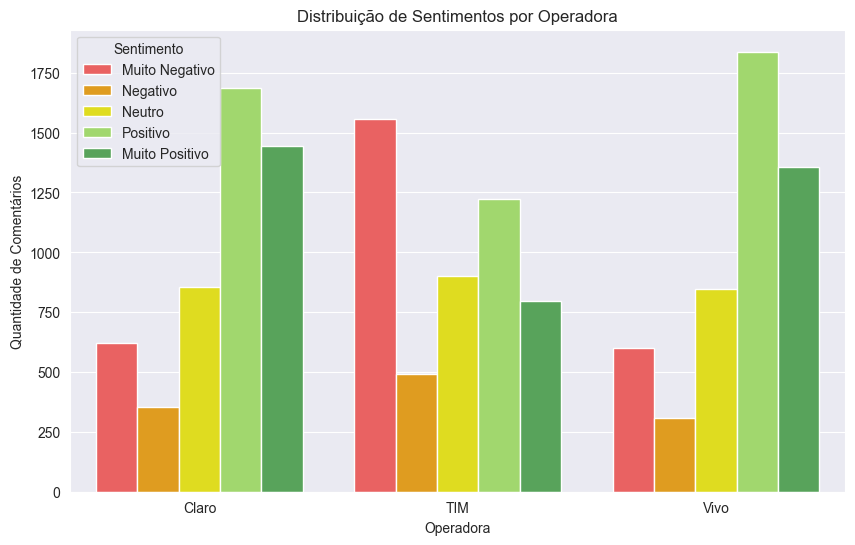

In [23]:
def map_sentiment(row):
    sentiment = row['sentiment_output']
    if sentiment == "NEG":
        prob = row.get('sentiment_NEG', 0)
        if prob < 0.8:
            return "Negativo"
        else:
            return "Muito Negativo"
    elif sentiment == "POS":
        prob = row.get('sentiment_POS', 0)
        if prob < 0.8:
            return "Positivo"
        else:
            return "Muito Positivo"
    elif sentiment == "NEU":
        prob_pos = row.get('sentiment_POS', 0)
        prob_neu = row.get('sentiment_NEU', 0)
        prob_neg = row.get('sentiment_NEG', 0)
        if prob_neu >= 0.7:
            return "Neutro"
        return "Positivo" if prob_pos > prob_neg else "Negativo"
    else:
        return sentiment
df['sentimento_complexo'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_complexo',
    palette={'Muito Negativo': '#FF4C4C', 'Negativo': '#FFA500', 'Neutro': "#FFFB00",
             'Positivo': "#A0E95C", 'Muito Positivo': '#4CAF50'},
    hue_order=['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo']
)

plt.title("Distribuição de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Comentários")
plt.legend(title="Sentimento")

plt.show()

In [28]:
values_claro = df[df['app'] == 'Claro'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_tim = df[df['app'] == 'TIM'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_vivo = df[df['app'] == 'Vivo'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

categories = ['Alegria', 'Tristeza', 'Raiva', 'Medo', 'Surpresa', 'Confiança', 'Confusão', 'Neutro']

# Valores de exemplo para cada operadora
values_vivo = values_vivo
values_tim = values_tim
values_claro = values_claro

# Criar subplots
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]]
)

# Gráfico Vivo
fig.add_trace(go.Scatterpolar(
    r=values_vivo,  # Não fechando a linha
    theta=categories,
    fill='toself',
    name='Vivo',
    line=dict(color='royalblue'),
    opacity=0.7
), row=1, col=1)

# Gráfico TIM
fig.add_trace(go.Scatterpolar(
    r=values_tim,
    theta=categories,
    fill='toself',
    name='TIM',
    line=dict(color='firebrick'),
    opacity=0.7
), row=1, col=2)

# Gráfico Claro
fig.add_trace(go.Scatterpolar(
    r=values_claro,
    theta=categories,
    fill='toself',
    name='Claro',
    line=dict(color='darkgreen'),
    opacity=0.7
), row=1, col=3)

# Ajustar o layout geral
fig.update_layout(
    showlegend=False,
    title_text="Distribuição de Emoções por Operadora",
    height=650, width=1800,
)

fig.update_layout(
    polar=dict(radialaxis=dict(visible=False)),
    polar2=dict(radialaxis=dict(visible=False)),
    polar3=dict(radialaxis=dict(visible=False))
)


# Ajuste do posicionamento dos títulos: mais para cima
fig.add_annotation(dict(font=dict(size=16),
                        x=0.13,
                        y=1.1,
                        showarrow=False,
                        text="Vivo",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.5,
                        y=1.1,
                        showarrow=False,
                        text="TIM",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.87,
                        y=1.1,
                        showarrow=False,
                        text="Claro",
                        xref="paper",
                        yref="paper"))

fig.show()


# Classificação de Temas

passar todo o tratamento no NLTK ou outras libs para fazer uma word cloud e saber os principais temas aboradas nos comentários


In [10]:
df = pd.read_csv("comentarios_processados.csv")

In [46]:
df['content_proc'].isnull().value_counts(normalize=True)

content_proc
False    0.992067
True     0.007933
Name: proportion, dtype: float64

In [63]:
# Remover valores nulos e garantir que tudo é string
docs = df['content_proc'].dropna().astype(str).tolist()

# Agora sim, aplicar BERTopic
topic_model = BERTopic(language="portuguese", calculate_probabilities=True, verbose=True)
temas_originais, _ = topic_model.fit_transform(docs)

2025-06-09 21:02:41,256 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 466/466 [00:54<00:00,  8.48it/s]
2025-06-09 21:03:39,754 - BERTopic - Embedding - Completed ✓
2025-06-09 21:03:39,755 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-09 21:03:48,441 - BERTopic - Dimensionality - Completed ✓
2025-06-09 21:03:48,444 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-09 21:04:43,189 - BERTopic - Cluster - Completed ✓
2025-06-09 21:04:43,193 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-09 21:04:43,466 - BERTopic - Representation - Completed ✓


In [64]:
topic_model.reduce_topics(docs, nr_topics=10)
temas_reduzidos = topic_model.transform(docs)[0]

2025-06-09 21:04:44,027 - BERTopic - Topic reduction - Reducing number of topics
2025-06-09 21:04:44,045 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-09 21:04:44,125 - BERTopic - Representation - Completed ✓
2025-06-09 21:04:44,128 - BERTopic - Topic reduction - Reduced number of topics from 226 to 10
Batches: 100%|██████████| 466/466 [00:40<00:00, 11.41it/s]
2025-06-09 21:05:25,196 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-06-09 21:05:25,234 - BERTopic - Dimensionality - Completed ✓
2025-06-09 21:05:25,235 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-06-09 21:05:26,032 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-06-09 21:06:22,219 - BERTopic - Probabilities - Completed ✓
2025-06-09 21:06:22,220 - BERTopic - Cluster - Completed ✓


In [71]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3300,-1_ter_app_aplicativo_conseguir,"[ter, app, aplicativo, conseguir, fazer, inter...",[nada funcionar app fazer dois dia conseguir a...
1,0,8011,0_bom_excelente_top_gostar,"[bom, excelente, top, gostar, otimo, polegarpa...","[bom, bom, bom]"
2,1,1601,1_app_aplicativo_conseguir_chip,"[app, aplicativo, conseguir, chip, ter, abrir,...","[bom app, app bom, bom app]"
3,2,688,2_internet_ter_propaganda_whatsapp,"[internet, ter, propaganda, whatsapp, celular,...","[internet bom, bom internet, internet]"
4,3,598,3_péssimo_ruim_horrível_nada,"[péssimo, ruim, horrível, nada, atualizar, res...","[péssimo, péssimo, péssimo]"
5,4,491,4_pagar_fatura_pagamento_conta,"[pagar, fatura, pagamento, conta, crédito, con...","[conseguir pagar fatura fazer, conseguir pagar..."
6,5,90,5_brasil_melhor_operadora_maravilha,"[brasil, melhor, operadora, maravilha, interne...","[melhor operadora brasil, melhor operadora bra..."
7,6,46,6_fibra_youtube_ultro_ter,"[fibra, youtube, ultro, ter, conseguir, app, n...","[abrir ultro fibra aplicativo, ter fibra opcao..."
8,7,37,7_coração_vermelho_coraçãovermelho_coraçãoroxo,"[coração, vermelho, coraçãovermelho, coraçãoro...","[coração vermelho, coração vermelho, coração v..."
9,8,19,8_regular_normal_novidade_enquanto,"[regular, normal, novidade, enquanto, experiên...","[regular, regular, regular]"


In [77]:
from collections import Counter

# Suponha que sua coluna se chame 'comentarios_tratados'
# e que cada linha seja uma string com palavras separadas por espaço

# 1. Juntar todos os comentários em uma única string
todos_os_comentarios = ' '.join(df['content_proc'].dropna())

# 2. Quebrar em palavras
palavras = todos_os_comentarios.split()

# 3. Contar com Counter
contagem = Counter(palavras)

# 4. Transformar em DataFrame, se quiser visualizar melhor
contagem_df = pd.DataFrame(contagem.items(), columns=['palavra', 'frequencia']).sort_values(by='frequencia', ascending=False)

contagem_df.head()


,palavra,frequencia
0,bom,5939
10,ter,2014
83,app,1933
17,aplicativo,1609
86,conseguir,1313


Passar um segundo filtro de palavras para a classificação

'ter', 'app', 'aplicativo', 'app'

In [75]:
for topic_num in topic_model.get_topics():
    print(f"Tema {topic_num}:")
    print(topic_model.get_topic(topic_num))
    print("-" * 40)


Tema -1:
[('ter', np.float64(0.043290192137629385)), ('app', np.float64(0.039257660381894044)), ('aplicativo', np.float64(0.03270728933254445)), ('conseguir', np.float64(0.03269691941932076)), ('fazer', np.float64(0.03239264147999001)), ('internet', np.float64(0.0313278314659419)), ('pra', np.float64(0.031083853847296887)), ('plano', np.float64(0.029275983672813)), ('ficar', np.float64(0.024685846836367008)), ('nada', np.float64(0.02447786655786395))]
----------------------------------------
Tema 0:
[('bom', np.float64(0.25333610657246414)), ('excelente', np.float64(0.08522282017278712)), ('top', np.float64(0.0614974925807147)), ('gostar', np.float64(0.05941282267235116)), ('otimo', np.float64(0.04885693110903545)), ('polegarparacima', np.float64(0.047366214380563834)), ('mãosaplaudindo', np.float64(0.04029346016194605)), ('prático', np.float64(0.03906652640189184)), ('parabéns', np.float64(0.036311521785832766)), ('melhor', np.float64(0.032713200076493636))]
--------------------------

In [74]:
topic_model.get_topic(-1)

[('ter', np.float64(0.043290192137629385)),
 ('app', np.float64(0.039257660381894044)),
 ('aplicativo', np.float64(0.03270728933254445)),
 ('conseguir', np.float64(0.03269691941932076)),
 ('fazer', np.float64(0.03239264147999001)),
 ('internet', np.float64(0.0313278314659419)),
 ('pra', np.float64(0.031083853847296887)),
 ('plano', np.float64(0.029275983672813)),
 ('ficar', np.float64(0.024685846836367008)),
 ('nada', np.float64(0.02447786655786395))]

In [66]:
# Passo 4: Adicionar coluna 'tema' reduzido no DataFrame
df["tema"] = temas_reduzidos

In [68]:
# Passo 6: Agregar por tema reduzido
df_tema = (
    df.groupby("tema")
    .agg(volume=("content_proc", "count"), sentimento_medio=("sentiment_output", lambda x: x.map({"POS": 1, "NEU": 0, "NEG": -1}).mean()))
    .reset_index()
)

In [69]:
# Passo 7: Calcular percentual
df_tema["volume_pct"] = df_tema["volume"] / df_tema["volume"].sum() * 100

# Passo 8: Obter rótulo mais representativo de cada grupo
df_tema["tema_nome"] = df_tema["tema"].apply(lambda x: topic_model.get_topic_info().set_index("Topic").loc[x]["Name"])

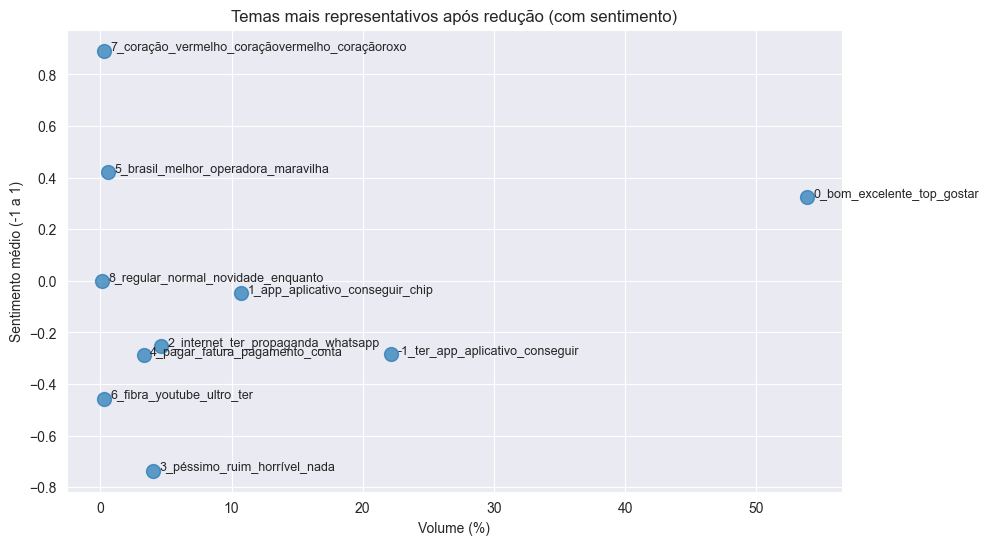

In [70]:
# Passo 9: Plotar gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_tema["volume_pct"], df_tema["sentimento_medio"], s=100, alpha=0.7)

# Anotar cada ponto
for _, row in df_tema.iterrows():
    plt.text(row["volume_pct"] + 0.5, row["sentimento_medio"], row["tema_nome"], fontsize=9)

plt.title("Temas mais representativos após redução (com sentimento)")
plt.xlabel("Volume (%)")
plt.ylabel("Sentimento médio (-1 a 1)")
plt.grid(True)
plt.show()

# Próximas Etapas a serem feitas

### Tratamentos
- **OK** - Extração 10k comentários
- **OK** - Apenas comentários de Android
- **OK** - Data mínima e máxima dos comentários de cada app, estão coesas
- **OK** - Ortográfia
- **OK** - Emoji
- **NOTOK** - Abreviações e gírias - Muito complicado para fazer

### Análise Exploratória
- **OK** - Data mínima e máxima dos comentários de cada app, estão coesas
- **OK** - Sentimento Geral por versão
- **OK** - Volume geral por versão do app
- **OK** - Nota média dos comentários por versão
- **NOTOK** - Ironia, classificou tudo como ironia
- **OK** - Os sentimentos como neutros tem a classificação entre 0,3 e 1,0. Não teria como classficar em positivos ou negativos
- **OK** - Separação de positivos e negativos fortes e fracos
- **WIP** - Periodicidade dos comentários para realizar uma análise ao decorrer do tempo de sentimento

### Análise Exploratória
- **WIP** - classificar os temas gerais
- **WIP** - classificar os temas de neutros
- **WIP** - scatterplot vendo o volume de temas
- **WIP** - mapa de wordcloud